## 6.2 图像卷积

### 6.2.1 互相关运算

In [2]:
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [3]:
def corr2d(X,K):
    '''计算二维相关运算'''
    h,w=K.shape
    Y=torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j]=(X[i:i+h,j:j+w]*K).sum()
    return Y

In [4]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 6.2.2卷积层

In [5]:
#实现二维卷积(与pytorch内置的相比简单了许多)

class Conv2D(nn.Module):                  #定义一个名为Conv2D的类，继承自PyTorch的nn.Module基类。所有神经网络模块都应该继承这个类。
    def __init__(self, kernel_size):
        super().__init__()               #调用父类nn.Module的初始化方法，这是PyTorch中必须的步骤。
        # torch.rand(kernel_size)：创建一个指定大小的随机张量，值在[0,1)之间均匀分布
        # nn.Parameter()：将张量包装成可训练的参数，这样在模型训练时可以被优化器自动更新
        # 这行代码定义了卷积层的权重参数
        self.weight = nn.Parameter(torch.rand(kernel_size))
        # torch.zeros(1)：创建一个值为0的一维张量
        # nn.Parameter()：同样包装成可训练参数
        # 这行代码定义了卷积层的偏置参数，初始化为0
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self, x):          #定义前向传播方法，这是所有nn.Module子类必须实现的方法，接收输入张量x。
        return corr2d(x, self.weight) + self.bias

### 6.2.3 图像中目标的边缘检测

In [6]:
X=torch.ones((6,8))
X[:,2:6]=0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [7]:
K=torch.tensor([[1.0,-1.0]])
Y=corr2d(X,K)
Y  #，输出Y中的1代表从白色到黑色的边缘，‐1代表从黑色到白色的边缘，其他情况的输出为0

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
#卷积核K只能检测垂直边缘
corr2d(X.t(),K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

###  6.2.4 学习卷积核

In [9]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)
# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2 # 学习率
for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat- Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    # conv2d.weight.data[:] -= ...：原地更新权重数据
    conv2d.weight.data[:]-= lr * conv2d.weight.grad  
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 6.459
epoch 4, loss 1.481
epoch 6, loss 0.412
epoch 8, loss 0.136
epoch 10, loss 0.050


Conv2d的用法

torch.nn.Conv2d(
    in_channels,           # 输入通道数
    out_channels,          # 输出通道数  
    kernel_size,           # 卷积核大小
    stride=1,              # 步长
    padding=0,             # 填充
    dilation=1,            # 膨胀率
    groups=1,              # 分组数
    bias=True,             # 是否使用偏置
    padding_mode='zeros',  # 填充模式
    device=None,           # 设备
    dtype=None             # 数据类型
)

In [10]:
conv2d.weight.data.reshape((1,2))

tensor([[ 0.9664, -1.0108]])

## 6.3 填充和步幅

### 6.3.1 填充

In [11]:
#在所有侧边填充一个元素

def comp_conv2d(conv2d,X):
    X=X.reshape((1,1)+X.shape)   #变成四维使能够放到conv2d里面
    Y=conv2d(X)
    return Y.reshape(Y.shape[2:])  # 省略前两个维度：批量大小和通道

conv2d=nn.Conv2d(1,1,kernel_size=3,padding=1)  #padding=1上下左右各填充一行
X=torch.rand(size=(8,8))
comp_conv2d(conv2d,X).shape   #8-3+1+2(上下左右都加了一行)=8

torch.Size([8, 8])

In [20]:
X=torch.ones([8,8])
X
(1,1)+X.shape

torch.Size([1, 1, 8, 8])

In [21]:
# 填充不同的高度和宽度
conv2d=nn.Conv2d(1,1,kernel_size=(5,3),padding=(2,1))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

### 6.3.2 步幅

In [22]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)   #[(8-3+2+2)/2]=[4.5]=4
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [14]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 6.4 多输入多输出通道

### 6.4.1 多输入通道

In [18]:
def corr2d_multi_in(X,K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    #zip是Python中一个非常实用的内置函数，用于将多个可迭代对象"打包"成元组序列。
    return sum(corr2d(x,k) for x,k in zip (X,K))

In [19]:
X = torch.tensor([[[0.0, 1.0, 2.0], 
                   [3.0, 4.0, 5.0], 
                   [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], 
                   [4.0, 5.0, 6.0], 
                   [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], 
                   [2.0, 3.0]], 
                  [[1.0, 2.0], 
                   [3.0, 4.0]]])
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [20]:
print(X.shape)  #2是通道维度
for i in zip(X,K):
    print(i)


torch.Size([2, 3, 3])
(tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]]), tensor([[0., 1.],
        [2., 3.]]))
(tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]]), tensor([[1., 2.],
        [3., 4.]]))


###  6.4.2 多输出通道

In [21]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X,k) for k in K],0)



In [22]:
#沿着第0维堆叠
K=torch.stack((K,K+1,K+2),0)
print(K)
K.shape

tensor([[[[0., 1.],
          [2., 3.]],

         [[1., 2.],
          [3., 4.]]],


        [[[1., 2.],
          [3., 4.]],

         [[2., 3.],
          [4., 5.]]],


        [[[2., 3.],
          [4., 5.]],

         [[3., 4.],
          [5., 6.]]]])


torch.Size([3, 2, 2, 2])

In [23]:
for k in K:
    print (k)

tensor([[[0., 1.],
         [2., 3.]],

        [[1., 2.],
         [3., 4.]]])
tensor([[[1., 2.],
         [3., 4.]],

        [[2., 3.],
         [4., 5.]]])
tensor([[[2., 3.],
         [4., 5.]],

        [[3., 4.],
         [5., 6.]]])


In [24]:
corr2d_multi_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

###  6.4.3 1×1卷积层

In [23]:
def corr2d_multi_in_out_1x1(X,K):   #相当于互相关函数
    c_i,h,w=X.shape
    c_o=K.shape[0]
    X=X.reshape((c_i,h*w))    #将矩阵拉成长条形
    K=K.reshape((c_o,c_i))
    Y=torch.matmul(K,X)     #矩阵乘法
    return Y.reshape((c_o,h,w))




In [26]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
print(X)

tensor([[[-1.1675, -0.3741,  0.9883],
         [ 0.0380,  1.9876,  1.8253],
         [ 0.3818, -0.7713, -0.5499]],

        [[-0.6143,  0.2144,  0.3805],
         [ 0.1412, -0.2354, -0.2985],
         [ 0.6053, -0.0913,  1.3064]],

        [[ 1.0834, -0.7765,  1.2792],
         [-0.0979, -0.4301, -1.5230],
         [ 0.2156, -0.0737,  0.3394]]])


In [27]:
Y1 = corr2d_multi_in_out_1x1(X, K)
print(Y1)
Y2 = corr2d_multi_in_out(X, K)
print(Y2)
assert float(torch.abs(Y1- Y2).sum()) < 1e-6   #是一个断言语句，用于验证两个张量 Y1 和 Y2 是否在数值上非常接近。如果条件为False，则抛出AssertionError。

tensor([[[ 2.3754, -0.7693, -0.0160],
         [-0.3101, -0.9716, -1.6857],
         [-0.9205,  0.4556, -1.4147]],

        [[ 0.5220, -0.6792,  1.2674],
         [-0.0560,  0.1137, -0.7862],
         [ 0.3092, -0.2477,  0.2437]]])
tensor([[[ 2.3754, -0.7693, -0.0160],
         [-0.3101, -0.9716, -1.6857],
         [-0.9205,  0.4556, -1.4147]],

        [[ 0.5220, -0.6792,  1.2674],
         [-0.0560,  0.1137, -0.7862],
         [ 0.3092, -0.2477,  0.2437]]])


## 6.5 池化层

### 6.5.1 最大池化层和平均池化层

In [28]:
def pool2d(X,pool_size,mode='max'):
    p_h,p_w=pool_size
    Y=torch.zeros((X.shape[0]-p_h+1,X.shape[1]-p_w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode =='max':
                Y[i, j]=X[i:i+p_h,j:j+p_w].max()
            elif mode=='avg':
                Y[i,j]=X[i:i+p_h,j:j+p_w].mean()
    return Y

In [29]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [30]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

###  6.5.2 填充和步幅

In [31]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [32]:
#默认情况下，深度学习框架中的步幅与汇聚窗口的大小相同。
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

nn.MaxPool2d()的用法：
torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, 
                   return_indices=False, ceil_mode=False)

kernel_size：池化窗口大小
可以是整数（如 2）或元组（如 (2, 2)）

stride：步长，默认为 kernel_size
如果是 None，则等于 kernel_size

padding：填充，默认为 0

dilation：膨胀率，默认为 1

return_indices：是否返回最大值的索引
用于后续的 MaxUnpool2d 操作

ceil_mode：输出形状计算模式
False（默认）：向下取整
True：向上取整

In [33]:
#填充和步幅可以手动设置
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [34]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(1, 1))
pool2d(X)

tensor([[[[ 1.,  3.],
          [ 9., 11.],
          [13., 15.]]]])

### 6.5.3 多个通道


In [35]:
#在处理多通道输入数据时，汇聚层在每个输入通道上单独运算，而不是像卷积层一样在通道上对输入进行汇总。这意味着汇聚层的输出通道数与输入通道数相同。

X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [36]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

##  6.6 卷积神经网络（LeNet）

### 6.6.1 LeNet

In [37]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),        #每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层。
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))


In [38]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)    #layer.__class__.__name__：获取层的类名

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


### 6.2.2 模型训练

In [39]:
from torchvision import transforms
from torch.utils import data
import torchvision
from IPython import display


batch_size = 256

def get_dataloader_workers():
    '''使用四个进程来读取'''
    return 4

def load_data_fashion_mnist(batch_size, resize=None): 
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    # transforms.ToTensor(): 将 PIL 图像或 numpy 数组转换为 PyTorch 张量，并自动归一化到 [0,1]
    # transforms.Resize(resize): 如果指定了 resize 参数，调整图像大小
    # transforms.Compose(trans): 组织多个变换操作成一个流水线，便于复用相同的预处理流程
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))
train_iter, test_iter =load_data_fashion_mnist(batch_size=batch_size)

In [40]:
class Accumulator: 
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


def accuracy(y_hat, y): 
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        # print(y_hat)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())



def evaluate_accuracy_gpu(net,data_iter,device=None):

    
    if isinstance(net,nn.Module):  #isinstance(对象, 类名):如果对象是指定类或其子类的实例，返回 True,否则返回 False
        net.eval()    #设置为评估模式,关闭 dropout 和 batch normalization 的随机性
        
        # 检查 device 参数是否为空（None、False、0、空字符串等）
        # 如果用户没有指定设备，就执行下面的自动检测逻辑
        # net.parameters()
        # 返回模型所有参数的迭代器
        # 这些参数是 nn.Parameter 对象，包含权重和偏置
        # iter(net.parameters())
        # 将参数迭代器转换为可迭代对象
        # next(iter(net.parameters()))
        # 获取第一个参数（任意一个参数都可以）
        # 因为所有参数都在同一个设备上
        # .device
        # 获取该参数所在的设备（CPU 或 GPU）
        if  not device:
            device = next(iter(net.parameters())).device
    #正确预测的数量，总预测的数量
    metric=Accumulator(2)
    with torch.no_grad():

        #  解释：将数据移动到指定设备：
        # 如果 X 是列表（如BERT的多输入），分别移动每个元素
        # 否则直接移动整个张量
        # 移动 y 到设备
        for X,y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
        return metric[0] / metric[1]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
def use_svg_display():
    # 设置Matplotlib使用SVG格式显示
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator: 
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):   
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

import time
class Timer: 
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()  
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()
    
def try_gpu(i=0): 
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。"""
    
    #     Xavier 均匀初始化公式
    # 从均匀分布 U[-a, a] 中采样，其中：
    # a = gain × √(6 / (fan_in + fan_out))
    # 公式解释
    # U[-a, a]：在 -a 到 a 之间的均匀分布
    # gain：缩放因子，取决于激活函数
    # fan_in：层的输入单元数
    # fan_out：层的输出单元数
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)  #将初始化函数应用到网络的所有模块
    print('training on', device)
    net.to(device)   #转移到GPU上  
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(3)   
        net.train()  #将模型设置为训练模式（启用dropout、batch norm等）
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()  #优化器步进：更新模型参数
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])  #累计损失（乘以批次大小得到总损失），累计正确预测数，累计样本数
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.465, train acc 0.825, test acc 0.816
81760.4 examples/sec on cuda:0


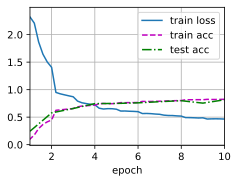

In [43]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())